<a href="https://colab.research.google.com/github/MatiasSiles/MastercardSalesOptimization/blob/main/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project only search predict the Mastercard Sales using a dataset more appropriate. I don't Data Wrangling because it is innecesary in this case and i want to focus in the most important

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.graph_objects import Candlestick, Figure

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [93]:
# Configuration
df = pd.read_csv("/content/Mastercard Dataset.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.loc[df.Date.dt.year >= 2018]
sales = df[["Date", "Close"]].set_index(df["Date"]).drop("Date", axis=1)

In [94]:
class Forecasting_Mastercard():
  def __init__(self, *, data, data_sales):
    self.data = data
    self.data_sales = data_sales

  class eda():
    def __init__(self):
      df = Forecasting_Mastercard.data
      sales = Forecasting_Mastercard.data_sales

    def stadistical_summary():
      return df.select_dtypes(exclude="datetime").describe().round(2)

    def plot_stock():
      df_plot_stock = df.drop(columns={"Adj Close","Volume"}, axis=1).set_index(df["Date"]).drop("Date", axis=1)

      Figure(data=[
          Candlestick(
              x=df_plot_stock.index, open=df_plot_stock["Open"], high=df_plot_stock["High"],
              low=df_plot_stock["Low"], close=df_plot_stock["Close"])
          ]).show()

    def high_low_volatility():
      df_high_low = df[["Date", "High", "Low"]].set_index(df["Date"]).drop("Date", axis=1)
      df_high_low = df_high_low["High"] - df_high_low["Low"]

      df_high_low.plot(figsize=(15,5))
      plt.show()

    def daily_returns():
      daily_returns = sales.Close.pct_change().dropna()

      fig, axes = plt.subplots(1, 2, figsize=(15,5))
      axes[0].hist(daily_returns)
      axes[1].boxplot(daily_returns)
      fig.suptitle("Relative Performance")
      plt.show()

    def volume_analysis():
      volume_hist = df[["Date","Volume"]].set_index(df["Date"]).drop("Date", axis=1)
      volume_vs_close = df[["Date","Close","Volume"]].set_index(df["Date"]).drop("Date", axis=1)

      fig, axes = plt.subplots(1, 2, figsize=(15,5))
      axes[0].scatter(volume_vs_close["Close"], volume_vs_close["Volume"])
      axes[0].set_xlabel("Close")
      axes[0].set_ylabel("Volume(relative)")

      axes[1].hist(volume_hist) # Millions to relative numbers, e.g: 3 Millions = 0.3
      axes[1].set_xlabel("Volume(relative)")
      axes[1].set_ylabel("Frequency")
      plt.show()

    def movil_trend(*, window):
      sma = sales.rolling(window=window).mean().dropna() # sma = simple movil average

      sma.plot(figsize=(15,5))
      plt.show()

  class models():
    def __init__(self, data):
      df = Forecasting_Mastercard.data
      sales = Forecasting_Mastercard.data_sales

    def forecasting():
      pass


    def detection_anomalies_sales(*, sales, contamination): # detect piks, dips and anomalies
      X = sales # because this model need a 2 dimensional container, not a serie, this is a serie but "[[]]" convert a df

      model = IsolationForest(contamination=contamination, random_state=42) # 5% data will be anomaly
      results = model.fit_predict(X)

      sales["anomalies"] = results
      anomalies = sales[sales["anomalies"] == -1]

      plt.figure(figsize=(15,5))
      sales["Close"].plot()
      plt.scatter(anomalies.index, anomalies["Close"], color='red', label="Anomalies")

      plt.legend()

Forecasting_Mastercard = Forecasting_Mastercard(data=df, data_sales=sales)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9eazomvg/yesh2rkc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9eazomvg/z0smttmi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99143', 'data', 'file=/tmp/tmp9eazomvg/yesh2rkc.json', 'init=/tmp/tmp9eazomvg/z0smttmi.json', 'output', 'file=/tmp/tmp9eazomvg/prophet_modeletp47sq0/prophet_model-20250628005553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:55:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:55:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Metrics:
MSE: 203.35
MAE: 10.79


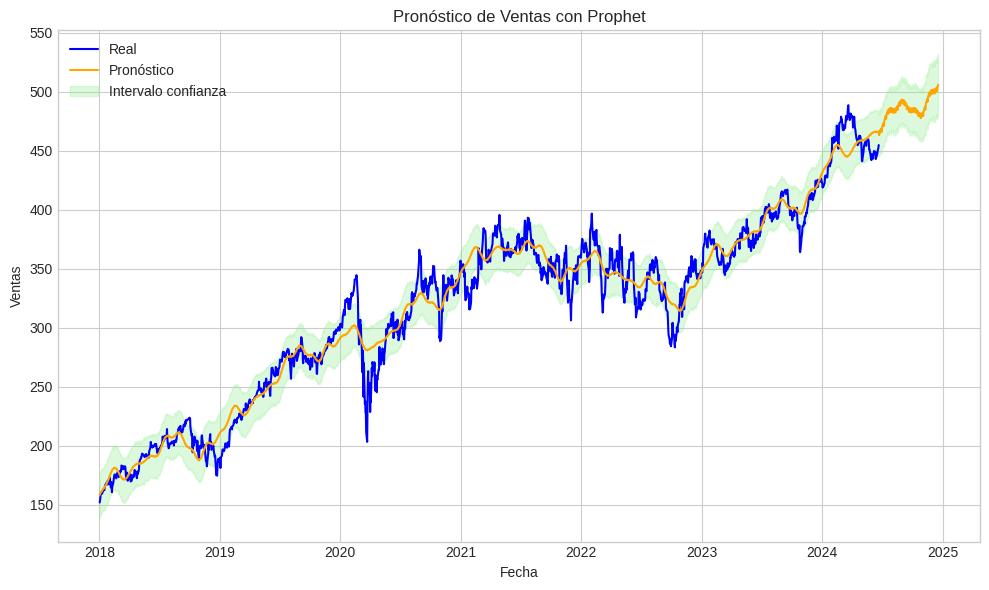

In [95]:
df = sales.reset_index()[["Date", "Close"]]
df.columns = ["ds", "y"]

modelo = Prophet(yearly_seasonality=True)
modelo.fit(df)

futuro = modelo.make_future_dataframe(periods=180)
forecast = modelo.predict(futuro)

plt.figure(figsize=(10, 6))
plt.plot(df["ds"], df["y"], label="Real", color="blue")
plt.plot(forecast["ds"], forecast["yhat"], label="Pronóstico", color="orange")
plt.fill_between(forecast["ds"],
                 forecast["yhat_lower"],
                 forecast["yhat_upper"],
                 color="lightgreen", alpha=0.3, label="Intervalo confianza")

# metrics
print("Metrics:")
print(f"MSE: {mean_squared_error(df['y'], forecast['yhat'].iloc[0:len(df)]):.2f}")
print(f"MAE: {mean_absolute_error(df['y'], forecast['yhat'].iloc[0:len(df)]):.2f}")

plt.title("Pronóstico de Ventas con Prophet")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [100]:
# tener los datos
# splitear datos en 80/20
# entrenar 2 modelos, uno para train y otro para test
# comparar mae y mse de ambos modelos
# si las metricas de test son mayores que train, hay overfitting

sales_search_overfitting = sales.reset_index()
sales_search_overfitting.columns = ["ds", "y"]
train_sales = sales.iloc[0: int(len(sales)*0.8)].reset_index()
test_sales = sales.iloc[int(len(sales)*0.8):].reset_index()

train_sales.columns = ["ds", "y"]
test_sales.columns = ["ds", "y"]

modelo = Prophet(yearly_seasonality=True).fit(sales_search_overfitting)
train_sales["predicts_train"] = modelo.predict(train_sales)["yhat"]
test_sales["predicts_test"] = modelo.predict(test_sales)["yhat"]

print("Metrics train:")
print(f"MAE: {mean_absolute_error(train_sales['y'], train_sales['predicts_train'])}")
print(f"MSE: {mean_squared_error(train_sales['y'], train_sales['predicts_train'])}")
print("Metrics test:")
print(f"MAE: {mean_absolute_error(test_sales['y'], test_sales['predicts_test'])}")
print(f"MSE: {mean_squared_error(test_sales['y'], test_sales['predicts_test'])}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9eazomvg/ojrydcq2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9eazomvg/lpvk4_1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87444', 'data', 'file=/tmp/tmp9eazomvg/ojrydcq2.json', 'init=/tmp/tmp9eazomvg/lpvk4_1d.json', 'output', 'file=/tmp/tmp9eazomvg/prophet_modelac9kik3n/prophet_model-20250628010727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:07:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:07:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Metrics train:
MAE: 11.094450061941837
MSE: 214.40431719168518
Metrics test:


KeyError: 'predicts_test'

In [ ]:
train_sales["y"]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def forecasting(end_date="2025-01-01", seasonal_periods=365, seasonal="add", trend="add"):
    # 1. Split datos
    split_idx = int(len(sales) * 0.8)
    train = sales.iloc[:split_idx]
    test = sales.iloc[split_idx:]

    # 2. Entrenar solo con train
    model = ExponentialSmoothing(train["Close"], trend=trend, seasonal=seasonal,
                                  seasonal_periods=seasonal_periods).fit()
    train["forecast"] = model.fittedvalues # modelo entrenado con train
    test_forecast = model.forecast(len(test)) # modelo entrenado con test

    # 3. Métricas
    print("Train Metrics:")
    print(f"MSE: {mean_squared_error(train['Close'], train['forecast']):.2f}")
    print(f"MAE: {mean_absolute_error(train['Close'], train['forecast']):.2f}")
    print("Test Metrics:")
    print(f"MSE: {mean_squared_error(test['Close'], test_forecast):.2f}")
    print(f"MAE: {mean_absolute_error(test['Close'], test_forecast):.2f}")

    # 4. Forecast futuro
    start_date_future = sales.index[-1] + pd.DateOffset(days=1)
    future_dates = pd.date_range(start=start_date_future, end=end_date, freq='D')
    forecast_future = model.forecast(len(future_dates))
    ci = 1.96 * np.std(forecast_future)

    df_future = pd.DataFrame({
        "forecast": forecast_future,
        "lower": forecast_future - ci,
        "upper": forecast_future + ci
    }, index=future_dates)

    # 5. Unir todo para graficar
    df_plot = pd.concat([train, test], axis=0)
    df_plot["forecast"] = pd.concat([train["forecast"], test_forecast])

    # 6. Plot
    plt.figure(figsize=(10,5))
    plt.plot(df_plot.index, df_plot["Close"], label="Real", color="royalblue")
    plt.plot(df_plot.index, df_plot["forecast"], label="Predicción", color="orange")
    plt.fill_between(df_future.index, df_future["lower"], df_future["upper"],
                     color='orange', alpha=0.2, label="Confianza 95%")

    plt.plot(df_future.index, df_future["forecast"], linestyle='--', color="orange")
    plt.title("Forecasting con Validación (Train/Test)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
forecasting()